# Active Contours

## Active Contours using Parametric Curves

In [205]:
from __future__ import division

from nt_toolbox.general import *
from nt_toolbox.signal import *
from numpy import *
import matplotlib.pyplot as plt
from cmath import *

#### Polygone initial

L'idée est d'associer les contours à des courbes paramétriques. Chaque courbe est discrétisée en p segments et est représentée par un vecteur complexe.

In [206]:
gamma0 = np.array([.78, .14, .42, .18, .32, .16, .75, .83, .57, .68, .46, .40, .72, .79, .91, .90]) + 1j*np.array([.87, .82, .75, .63, .34, .17, .08, .46, .50, .25, .27, .57, .73, .57, .75, .79])

#### Visualisation de la courbe initiale

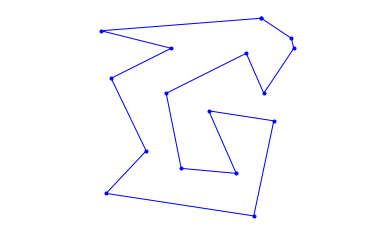

In [207]:
periodize = lambda gamma: concatenate((gamma, [gamma[0]]))
def cplot(gamma,s='b',lw=1): 
    plt.plot(real(periodize(gamma)), imag(periodize(gamma)), s, linewidth=lw)
    plt.axis('equal')
    plt.axis('off')
    
cplot(gamma0,'b.-');

Nombre de points de la courbe discrète (= nombre de segments) :

In [208]:
p = 256

En fonction de la longueur d'un arc (ie: un segment), nous allons échantillonner différemment la courbe. Les lignes de code ci dessous permettent de définir des fonctions utilisées par la suite pour obtenir une courbe "lisse".


In [209]:
# ?????


# interpc : fonction prenant trois arguments et donnant un complexe
#interp : interpole les vecteurs de données xf et real(yf) (ou imag(yf)) et évalue les valeurs obtenues en x
interpc = lambda x,xf,yf: interp(x,xf,real(yf)) + 1j * interp(x,xf,imag(yf))
#curvabs: fonction prenant en entrée gamma (vecteur), puis retourne un vecteur commençant par 0 et la somme cumulée 
# de la différence entre gamma sans le premier terme et gamma sans le dernier terme
curvabs = lambda gamma: concatenate( ([0], cumsum( 1e-5 + abs(gamma[:-1:]-gamma[1::]) ) ) )

#arange(0,p) = vecteur de 0 à p-1 --> est bien composé de p points.
#resample1 calcule l'interpolation entre un vecteur de 0 à p-1 pris en entrée et normalisé et le vecteur d  divisé par
# d[-1] et gamma
resample1 = lambda gamma,d: interpc(arange(0,p)/float(p),  d/d[-1],gamma)
#periodize: fonction créée plus haut. Concatène le vecteur d'entrée avec sa première composante
resample = lambda gamma: resample1( periodize(gamma), curvabs(periodize(gamma)) )

#### Courbe initiale $\gamma_{1}(t)$

In [210]:
gamma1 = resample(gamma0)

#### Visualisation de la courbe initiale $\gamma_{1}(t)$

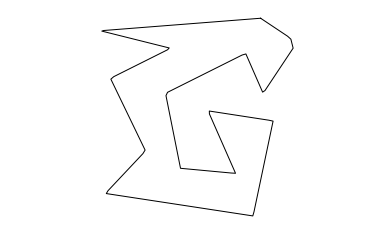

In [211]:
cplot(gamma1, 'k')

#### Différence finies
On définit ci-dessous des raccourcis pour certaines fonctions : le décalage des données vers la gauche ou vers la droite, le décentrage en amont (forward differences: FwdDiff) et le décentrage en aval (backward differences: BwdDiff).

Ces décentrages sont définis respectivement par: $\nabla f_p = f_{p+1} - f_p$ et $\nabla f_p = f_p - f_{p-1}$.

In [212]:
shiftG = lambda c: concatenate( ([c[-1]],c[:-1:]) ) #Décalage des données (en entrée de la fonction) vers la gauche
shiftD = lambda c: concatenate( (c[1::],[c[0]]) ) #Décalages des données vers la droite (donc dernier élement devient le premier)
BwdDiff = lambda c: c - shiftG(c) #grad f_p = f_p - f_{p-1}  avec f_{p-1} la courbe paramétrée avec p-1
FwdDiff = lambda c: shiftD(c) - c

#### Calcul de la tangente et de la normale à une courbe

In [213]:
normalize = lambda v: v/maximum(abs(v),1e-10) #normalisation, fonction maximum utilisée afin de ne pas diviser par 0
tangent = lambda gamma: normalize( FwdDiff(gamma) ) #par définition
normal = lambda gamma: -1j*tangent(gamma) #par définition

#### Déplacement de la courbe dans la direction de sa normale

In [214]:
delta = .03
gamma2 = gamma1 + delta * normal(gamma1) #dans la direction de la normale
gamma3 = gamma1 - delta * normal(gamma1) #dans la direction opposée à la normale

#### Visualisation des courbes définies précédemment

(0.09818192340611909,
 0.979037189504653,
 0.011000256259768859,
 0.942237845572892)

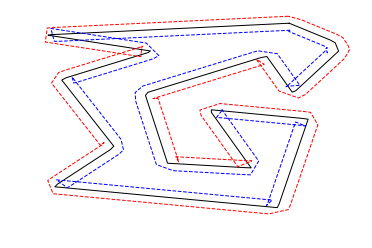

In [215]:
cplot(gamma1, 'k') #noir: courbe initiale lissée (après interpolation)
cplot(gamma2, 'r--') #rouge: direction de la normale --> courbe plus à l'extérieur
cplot(gamma3, 'b--') #bleu: direction opposée à la normale --> courbe à l'intérieur de la courbe initiale
plt.axis('tight') 
plt.axis('off')

 ### Evolution by mean curvature

On appelle évolution d'une courbe une série de courbes $\gamma_s$ indexées par un paramètre d'évolution $s$.
Afin d'évaluer la courbe intiale, dans notre cas : $\gamma_0$, il suffit de minimiser son énergie $E(\gamma)$ par une méthode de descente du gradient: $$\frac{\partial{\gamma}}{\partial{s}} = \nabla E(\gamma_s)$$

Chacune des courbes dans la série peut être pensée comme une surface de Riemann. 

La manière la plus simple d'obtenir l'évolution d'une courbe est la méthode de "mean curvature", que l'on peut traduire par méthode de "courbure moyenne". Cela correspond à trouver le minimum de la longueur de la courbe:
$$E(\gamma) = \int_0^1 ||\gamma ' (t)|| dt $$

Ce minimum sera trouvé grâce à la méthode de descente du gradient.

Le gradient de cette longueur est:
$$ \nabla E(\gamma)(t) = -K_\gamma(t) n_\gamma(t) $$

avec $K$ la courbure, définie par: $ K_\gamma(t) = \frac{1}{||\gamma'(t)||} <t'_\gamma(t),n_\gamma(t)>$


Un autre raccourci pour la suite est la fonction normalC, qui sera utilisée pour trouver le gradient $\nabla E(\gamma)(t)$.

In [216]:
normalC = lambda gamma: BwdDiff(tangent(gamma)) / abs( FwdDiff(gamma) )

Définissons à présent l'intervalle de temps dt, la durée totale de l'évolution Tmax et le nombre maximal d'itérations niter. A cause de la forte courbure de la forme étudiée, nous devons choisir un intervalle de temps petit. Sinon, la méthode du gradient n'aboutirait pas à un bon résultat puisque $\gamma$ subirait des changements trop importants au cours de son évolution.

In [217]:
dt = 0.001 / 100

In [218]:
Tmax = 3.0 / 100
niter = round(Tmax/dt) #3000

$\gamma$ au temps $s=0$ prend la valeur de $\gamma_1$, c'est à dire de la forme initialement étudiée.

In [219]:
gamma = gamma1

#### Evolution de la courbe $\gamma$

Cette évolution correspond à la méthode de descente du gradient : $$\gamma = \gamma - dt * \nabla E(\gamma)(t) = \gamma + dt * K_\gamma(t) n_\gamma(t)$$

In [220]:
gamma = gamma + dt * normalC(gamma)

Un ré-échantillonnage de la courbe est appliqué afin de stabiliser la vitesse d'évolution, ceci ayant pour but de pouvoir mener à bien la descente du gradient.

In [221]:
gamma = resample(gamma)

#### Exercice 1:  Perform the curve evolution. You need to resample it a few times.

Dans cet exercice, nous voulons montrer l'évolution de la courbe paramétrique illustrée avant. Nous choisissons d'afficher 10 courbes intermédiaires différentes du processus. Dans la sortie, la courbe bleue en pointillés la plus interne correspond à la dernière itération, tandis que la plus externe correspond à la première. Les 8 courbes rouges décrivent l'évolution de la courbe en allant de l'extérieur vers l'intérieur.

Sur 3000 itérations, 3000 échantillonages ont été effectués, et 10 courbes seulement permettent de bien se rendre compte du cheminement de l'algorithme. Grâce à celles-ci, il est possible de visualiser la descente du gradient. De manière générale, la méthode de descente du gradient converge de moins en moins vite vers un minimum. C'est le cas ici. Plus on s'éloigne de la courbe extérieure (la première itération équivaut à la courbe bleue externe), moins l'écart entre les courbes est grand. Pourtant, l'écart en terme de nombre d'itérations est bien constant entre deux courbes. Cela signifie bien que, pour un même nombre d'itérations, plus on approche d'un minimum, plus la courbe a une faible évolution.

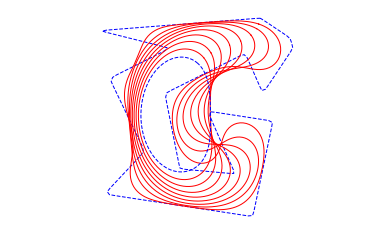

In [222]:
aff = np.around(linspace(1,niter,10)) #liste utilisée pour l'affichage.
#On veut avoir 10 courbes : on initialise un vecteur de 10 valeurs réparties équitablement entre 1 et niter=3000.

k = 0 #initialisation de la variable parcourant aff

for i in range (1,niter+1): #1 à 3000
    gamma = resample(gamma + dt*normalC(gamma)) # échantillonage à chaque itération
    if i==aff[k] :
        if (i==1 or i==niter) :  #courbe la plus au centre ou plus à l'extérieur, ie: 1ère valeur de aff ou dernière
            cplot(gamma, 'b--') #alors on dessine en pointillés noirs
        else:
            cplot(gamma, 'r')
             #sinon on dessine en trait plein rouge          
        k = k+1

### Geodesic Active Contours

Le principe est le même que précédemment sauf que nous allons utiliser la longueur pondérée de la courbure. La nouvelle énergie à minimiser est donc :
$$E(\gamma) = \int_0^1 W(y(t))||\gamma ' (t)|| dt $$

$W > 0$ est une métrique géodésique, c'est-à-dire que ce sont les poids correspondant aux chemins les plus courts, s'ils existent, entre deux points.
Là où l'image doit être segmentée, $W$ sera petit.

In [223]:
n = 200 #taille de l'image

La première étape consiste donc à créer ce vecteur de poids.

Pour ce faire, on définit la variable $theta$ comme un tableau de nbumps éléments aléatoirement choisis entre 0 et 1, puis multipliés par $2\pi$.



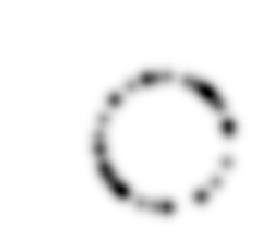

In [224]:
nbumps = 40
theta = random.rand(nbumps,1)*2*pi

r = .6*n/2 #rayon
a = np.array([.6*n,.6*n]) #n est la taille de l'image

# ??????
A0 = int(a[0]) + r*np.cos(theta) 
A1 = int(a[1]) + r*np.sin(theta) 

#pour avoir des coordonnées entières
x = around(A0) 
y = around(A1)

# ????
W = zeros([n,n]) 
for i in arange(0,nbumps): 
    W[int(x[i]),int(y[i])] = 1 #coeff de W prennent la valeur de 1 lorsque correspondent à des données sur le cercle?....
    
W = gaussian_blur(W,6.0) #filtre gaussien appliqué pour le floutage
W = rescale(-minimum(W,.05), .3,1) #rééchantillonne les données dans l'intervalle [0.3,1]

#Visualisation
imageplot(W)

On cherche désormais à visualiser la norme du gradient des poids : $||\nabla W||$.

In [225]:
G = grad(W) #calcul du gradient
G = G[:,:,0] + 1j*G[:,:,1] 

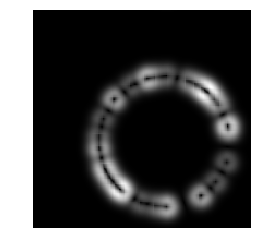

In [226]:
#visualisation de la norme du gradient de W
imageplot(abs(G))

L'image ci-dessus paraît complémentaire à l'image précédemment visualisée. Les parties avec plus ou moins d'intensité coïncident dans les deux cas.

Définissons des fonctions pour évaluer le gradient et le potentiel le long d'une courbe :

In [227]:
EvalG = lambda gamma: bilinear_interpolate(G, imag(gamma), real(gamma))
EvalW = lambda gamma: bilinear_interpolate(W, imag(gamma), real(gamma))

On créé une courbe circulaire $\gamma_0$ de rayon $r$, contenant $p$ points sur la courbe :

In [228]:
#rayon
r = .98*n/2 
#nombre de points sur la courbe
p = 128 

#transposée d'un vecteur de longueur p+1 allant de 0 à 2pi (intervalles égaux)
theta = transpose( linspace(0, 2*pi, p+1) )

#sans la derniere valeur, car cos(0)=cos(2pi) et idem pour sin
theta = theta[0:-1] 

#courbe circulaire
gamma0 = n/2 * (1 + 1j) +  r*(np.cos(theta) + 1j*np.sin(theta)) 

On procède à l'initialisation de $\gamma_{0}$, des intervalles de temps et du nombre d'itérations.

Dans ce cas, $dt$ est plus grand qu'avant car la courbe se situe dans le domaine $\left[0,n+1\right]x\left[0,n+1\right]$.

In [229]:
gamma = gamma0

In [230]:
dt = 1 #intervalle de temps
Tmax = 5000 #durée max
niter = round(Tmax/ dt) #nombre d'itérations

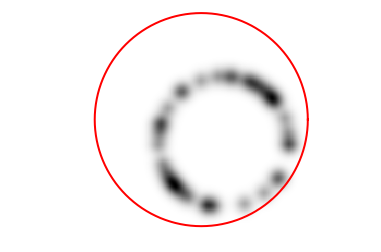

In [231]:
lw = 2 #largeur du trait
plt.clf
imageplot(transpose(W)) #visualisation des poids
cplot(gamma, 'r', lw) #visualisation de la courbe

Pour cette courbe, le gradient de l'énergie est :
$$ \nabla E(\gamma) = -W(\gamma(t)) K_\gamma(t)n_\gamma(t)  +   <\nabla W(\gamma(t)),n_\gamma(t)> n_\gamma(t). $$

Le produit scalaire est défini par la fonction ci-dessous.

In [232]:
dotp = lambda c1,c2: real(c1)*real(c2) + imag(c1)*imag(c2) #produit scalaire

#### Evaluation de la courbe.

Pour ce faire, rappelons que :

EvalW(gamma) correspond à $W(\gamma(t))$,

normalC(gamma) correspond à $K_\gamma(t)n_\gamma(t)$,

dotp(EvalG(gamma), N) correspond à $<\nabla W(\gamma(t)),n_\gamma(t)> $,

et enfin normal(gamma) correspond à $n_\gamma(t)$, la normale.

In [233]:
N = normal(gamma)
g = - EvalW(gamma) * normalC(gamma) + dotp(EvalG(gamma), N) * N
gamma = gamma - dt*g

In [234]:
gamma = resample(gamma) #échantillonage

#### Exercise 2: Perform the curve evolution.

Nous implémentons dans cet exercice l'évolution du cercle rouge. Nous utilisons la même méthode que dans le premier exercice. Le principe est d'utiliser un vecteur de 10 coefficients (pour les 10 courbes ou 10 étapes d'évolution) uniformément répartis entre 1 et le nombre d'itérations. Le but est en quelque sorte d'"immortaliser" l'évolution de la courbe à certaines étapes (ici: 10 à intervalles de temps régulier). On effectue la méthode de descente du gradient pour chacune des itérations. L'immortalisation se traduit par l'affichage d'une courbe rouge. 

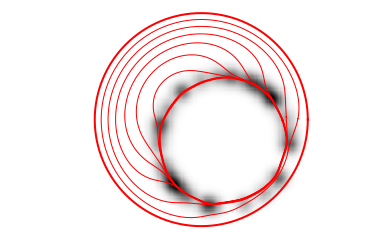

In [235]:
aff = around(linspace(1,niter,10)) #affichage de 10 courbes
k = 0
plt.clf
imageplot(transpose(W))
for i in range(1,niter+1):
    N = normal(gamma)
    g = -EvalW(gamma)*normalC(gamma) + dotp(EvalG(gamma),N)*N
    gamma = resample(gamma - dt*g)  #échantillonage à chaque boucle  
    if i==aff[k]:
        if (i==1 or i==niter):
            cplot(gamma, 'r',lw) #pour courbes aux extrémités
        else:
            cplot(gamma, 'r') #pour courbes internes
        k = k+1

### Medical Image Segmentation

Il est aussi possible d'utiliser une métrique basée sur une étude de gradient pour détecter des contours. Appliquons cette méthode sur une image médicale par exemple.

/home/lcouret/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/lcouret/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


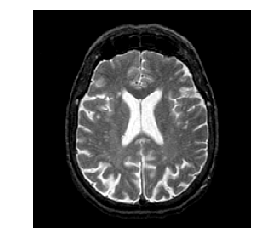

In [236]:
n = 256
name = 'nt_toolbox/data/cortex.bmp'
f = load_image(name, n) #download image
imageplot(f) #affichage

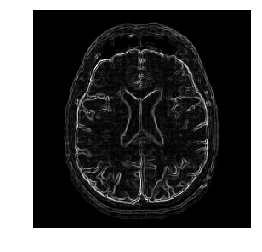

In [237]:
G = grad(f) #calcul du gradient de l'image
d0 = np.sqrt(sum(G**2, 2)) #calcul de la norme 2 du gradient
imageplot(d0) #affichage

Ce détecteur de contours est une fonction de la magnitude du gradient et est décroissante. Nous allons tout d'abord flouter l'image par un facteur $a$. Pour cela, on applique une matrice de floutage sur chaque élément de la matrice de l'image.

Un exemple de matrice de floutage de type gaussien (dimension 3) :

$$ \frac{1}{a}
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}$$

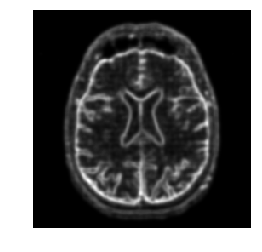

In [238]:
a = 2 #coefficient de floutage
d = gaussian_blur(d0, a) #d0 image initiale --> floutage gaussien appliqué avec coefficient a
imageplot(d) #affichage

In [239]:
d = minimum(d, .4) #minimum entre les valeurs après floutage et 0.4
W = rescale(-d, .8, 1) #redéfinition des poids W, échantillonés dans l'intervalle [0.8,1]

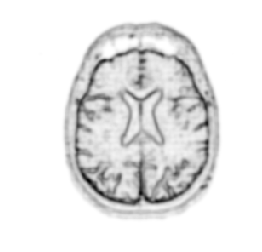

In [240]:
imageplot(W) #affichage des poids une fois redéfinis

Nombre de points sur la courbe :

In [241]:
p = 128 #nombre de points sur la courbe

#### Exercise 3: Create an initial circle $\gamma_0$ of $p$ points. When plotting the image, you need to transpose it to have axis coherent with the cplot.

La courbe initiale est le cercle rouge.

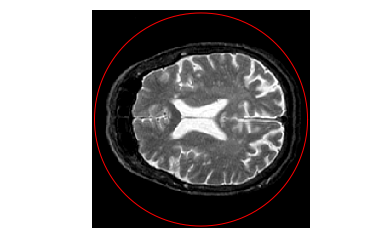

In [242]:
#redéfinition du rayon et de theta (car n a changé), idem pour gamma0
r = .98*n/2;
theta = transpose(linspace(0,2*pi,p+1))
theta = theta[0:-1] #sans derniere valeur (toujours car cos(0)=cos(2pi))
gamma0 = n/2*(1 + 1j) +  r*(np.cos(theta) + 1j*np.sin(theta)) #première courbe = cercle

#affectation
gamma = gamma0; #initialisation de l'évolution
#affichage
plt.clf
imageplot(transpose(f)) #transposée de l'image selon la consigne
cplot(gamma,'r')

Passons à la visualisation de l'évolution de la courbe :

In [243]:
dt = 2 #intervalle de temps

In [244]:
Tmax = 9000 #temps max
niter = round(Tmax/ dt) #nombre max d'itérations

#### Exercise 4: Perform the curve evolution.

A nouveau, nous appliquons le même raisonnement pour calculer l'évolution de la courbe.
A chaque itération nous ré-évaluons $\gamma$ et nous l'affichons à 10 étapes équitablement réparties tout au long de l'évolution.

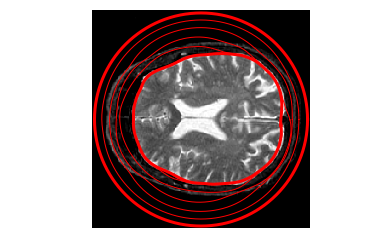

In [245]:
# on prend G=grad(W) car on part des poids 
G= grad(W) 
G = G[:,:,0] + 1j*G[:,:,1] # ?????

#largeur du cercle
lw = 3

#indices pour lesquels on trace la courbe
aff = around(linspace(1,niter,10))

k = 0
plt.clf
imageplot(transpose(f))
for i in range(1,niter+1):
    N = normal(gamma)
    #réutilisation de EvalW et EvalG (définis avant)
    g = -EvalW(gamma)*normalC(gamma) + dotp(EvalG(gamma), N)*N 
    #échantillonage à chaque itération 
    gamma = resample(gamma - dt*g) 
    if i==aff[k]:
        if (i==1 or i==niter):
            cplot(gamma, 'r', lw)
        else:
            cplot(gamma, 'r')
        k = k+1

### Evolution of a Non-closed Curve

Pour finir, nous allons étudier le cas des courbes non fermées, en ajoutant des conditions aux frontières. Nommons par exemple ces deux contraintes :
$\gamma(0) = x_0$ et $\gamma(1) = x_1$.

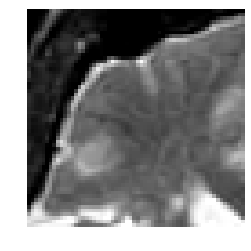

In [246]:
n = 256
f = f[45:105, 60:120] #on étudie seulement une partie de l'image
n = f.shape[0] #n prend la valeur du nombre de lignes de la matrice de pixels (égale ici au nombre de colonnes = 60)

#affichage du carré de l'image étudié
imageplot(f)

#### Exercise 5: Compute an edge attracting criterion W(x)>0, that is small in area of strong gradient.

Le but de cet exercice est d'obtenir l'image précédemment affichée avec des intensités différentes en fonction du gradient. Ainsi, on aura bien une image où les contours pourront être plus facilement repérés.

Nous calculons dans un premier temps le gradient de l'image et sa norme. L'idée est ensuite d'accentuer au maximum les propriétés de l'image pour détecter plus facilement les contours. Pour se faire nous filtrons l'image (convolution) par un filtre gaussien. Enfin, nous souhaitons un critère de détection de bords petit là où le gradient est grand. C'est pourquoi nous donnons la valeur de 0.3 à chacun des pixels où le gradient serait plus élevé que ce seuil.

Pour affiner le critère de détection, il suffirait alors de diminuer le seuil de tolérance. En prenant par exemple un seuil à 0.2, la visualisation des poids amène à un bord nettement plus distinct. Un seuil de tolérance trop bas n'est en revanche d'aucune utilité. Cela mène à une image où les bords sont très épais. Ceci n'a aucun intérêt car alors, en poussant ce problème à sa limite, toute l'image deviendrait un bord. Nous pouvons noter que ce phénomène d'élargissement progressif des contours est dû au filtre gaussien convolué avant à l'image. Le seuil devenant de plus en plus petit il est normal que de moins en moins de valeurs y soit inférieures.

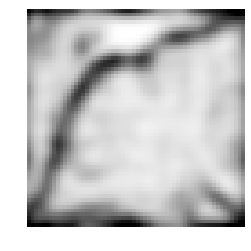

In [247]:
#gradient de f
G = grad(f)
#G0 : norme 2 du gradient
G0 = np.sqrt(sum(G**2, 2))
G = gaussian_blur(G0,a) #afin d'accentuer les valeurs dans l'image (--> filtre gaussien)
G = minimum(G,.3) #0.3 si "strong gradient" ie: dans les régions où G est elevé alors G prendra la valeur de 0.3 (petit)
W = rescale(-G,.4,1)
plt.clf
imageplot(W)

Définition des contraintes: $x_0$ et $x_1$.

In [248]:
x0 = 4 + 55j
x1 = 53 + 4j

In [249]:
p = 128 #nombre de points de la courbe
t = transpose(linspace(0, 1, p))
gamma0 = t*x1 + (1-t)*x0 #premiere courbe

In [250]:
gamma = gamma0 #initialisation de l'évolution avec la courbe initiale


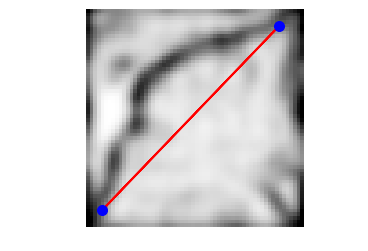

In [251]:
plt.clf
imageplot(transpose(W))
cplot(gamma,'r', 2)
plt.plot(real(gamma[0]), imag(gamma[0]), 'b.', markersize=20)
plt.plot(real(gamma[-1]), imag(gamma[-1]), 'b.', markersize=20);

Définitions de fonctions pour les courbes non périodiques.

In [252]:
curvabs = lambda gamma: concatenate( ([0], cumsum( 1e-5 + abs(gamma[:-1:]-gamma[1::]) ) ) )
resample1 = lambda gamma,d: interpc(arange(0,p)/float(p-1),  d/d[-1],gamma)
resample = lambda gamma: resample1( gamma, curvabs(gamma) )

In [253]:
dt = 1/10 #intervalle de temps
Tmax = 2000*4/ 7
niter = round(Tmax/ dt) #nombre maximal d'itérations

#### Exercise 6: Perform the curve evolution. Be careful to impose the boundary conditions at each step.

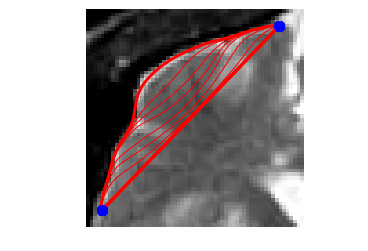

In [254]:
G = grad(W) #gradient des poids W
G = G[:,:,0] + 1j*G[:,:,1]

lw = 3 

aff = around(linspace(1,niter,10))

k = 0
plt.clf
imageplot(transpose(f))

for i in range(1,niter+1):
    N = normal(gamma)
    g = - EvalW(gamma)*normalC(gamma) + dotp(EvalG(gamma),N)*N
    gamma = resample(gamma - dt*g) #échantillonage à chaque itération
    gamma[0] = x0
    gamma[-1] = x1 #contraintes aux frontières à ajouter à chaque itération
    if i==aff[k]:
        if (i==1 or i==niter):
            cplot(gamma, 'r', lw)
        else:
            cplot(gamma, 'r')
        k = k+1
        plt.plot(real(gamma[0]), imag(gamma[0]), 'b.', markersize=20)
        plt.plot(real(gamma[-1]), imag(gamma[-1]), 'b.', markersize=20);

## Bibliographie